In [68]:
import cv2
import pickle
import pixy2
import numpy as np
import time
import math
import IPython
from recordclass import recordclass
from matplotlib.pyplot import imshow as show
from scipy.signal import find_peaks
from sklearn.cluster import KMeans

In [147]:
with open('dataset/pixy2_vector_dataset.obj', 'rb') as f:
    data = pickle.load(f)
    width, height = data[0]
    frames = data[1:]
    fps = 60

In [149]:
def imshow(img):
    _, ret = cv2.imencode('.jpg', img)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [150]:
Pixy2FrameIndex = recordclass('Pixy2FrameIndexes', 'index age last_active')

def create_image_from_vectors(frame, height, width, previous_frame_indexes, frame_index, fps, min_age):
    img = np.zeros([height, width], dtype=np.uint8)
    new_indexes = []
    current_time = frame_index * 1 / fps # measured in seconds
    max_inactive_time = 3.0 # measured in seconds
    
    # for each detected vector
    for vect in frame:
        
        current_index = vect.index
        
        # for every old vector that was once detected
        found_index = False
        for i in range(len(previous_frame_indexes)):
            previous_index, age, _ = previous_frame_indexes[i]
            # check if the age of an old vector is greater than the accepted minimum
            if age >= min_age:
                # if found an old vector that matches the current one
                if current_index == previous_index:
                    # draw it and update it's last active time
                    cv2.line(img, (vect.x0, vect.y0), (vect.x1, vect.y1), color=255, thickness=1)
                    previous_frame_indexes[i].last_active = current_time
                    found_index = True
        
        # if the new detected vector isn't in the list of old vectors
        if not found_index:
            # then add it to that list
            new_indexes.append(Pixy2FrameIndex(index=current_index, age=1, last_active=current_time))
    
    # remove old vectors that haven't been active for a while
    # part of the cleanup because there can only be 256 vectors tracked
    aux = []
    for index in previous_frame_indexes:
        index.age += 1
        if index.last_active + max_inactive_time >= current_time:
            aux.append(index)
    previous_frame_indexes = aux
    
    # add old indexes to the new indexes
    new_indexes += previous_frame_indexes
        
    return img, new_indexes
 
def create_video_from_vectors(output, frames, height, width, fps, min_age):
    fourcc = cv2.VideoWriter_fourcc(*'MP42')
    video = cv2.VideoWriter(output, fourcc, float(fps), (width, height), 0)
    images = []
    indexes = []
    
    for frame_index, frame in enumerate(frames):
        img, indexes = create_image_from_vectors(frame, height, width, indexes, frame_index, fps, min_age)
        images.append(img)
        video.write(img)
        
    video.release()
    
    return images, indexes

In [151]:
min_age_A = 1
min_age_B = 3
imgs, indexes = create_video_from_vectors('videos/pixy2_lane_follower_age{}.avi'.format(min_age_A), frames, height, width, fps, min_age_A)
imgs, indexes = create_video_from_vectors('videos/pixy2_lane_follower_age{}.avi'.format(min_age_B), frames, height, width, fps, min_age_B)

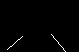

In [6]:
imshow(imgs[20])

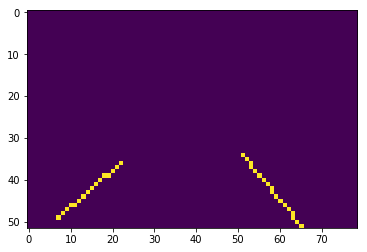

In [7]:
show(imgs[20])

In [145]:
def calc_lanes(peaks, warped):
    no_peaks = len(peaks)
    line_threshold = warped.shape[0] // 2
    lanes = []
    
    # peaks is an ordered list
    if no_peaks > 0:
        lines = cv2.HoughLinesP(warped, rho=2, theta=4*np.pi/180, threshold=200, minLineLength=50, maxLineGap=100)
        if lines is None:
            return None
        if len(lines[:,0,:]) >= no_peaks:
            kmeans = KMeans(n_clusters=no_peaks)
            kmeans.fit(lines[:,0,:])
            vectors = kmeans.cluster_centers_
            filtered = []
            for vector in vectors:
                y0 = vector[1]
                y1 = vector[3]
                if not (y0 <= line_threshold and y1 <= line_threshold):
                    filtered.append(vector)
            vectors = filtered
            return vectors
        else:
            return None
    else:
        return None

def detect_lane_from_image(img, height, width):
    # region of interest
    a = (0, height-1)
    b = (25, 30)
    c = (53, 30)
    d = (width-1, height-1)
    pts1 = np.float32([a, b, c, d])
    height = width = 500
    pts2 = np.float32([[0, height-1], [0, 0], [width-1, 0], [width-1, height-1]])
    
    # draw the region of interest
    roi = np.array(img, copy=True)
    cv2.line(roi, a, b, color=128, thickness=1)
    cv2.line(roi, b, c, color=128, thickness=1)
    cv2.line(roi, c, d, color=128, thickness=1)
    cv2.line(roi, d, a, color=128, thickness=1)
    
    # get perspective and warp the image
    transform = cv2.getPerspectiveTransform(pts1, pts2)
    warped = cv2.warpPerspective(img, transform, (width, height))
    
    # along the columns
    hist = warped.sum(axis = 0)
    
    # find peaks in the histogram
    peaks, _ = find_peaks(hist, prominence=1000, height=2000, distance=125)
    
    lanes = calc_lanes(peaks, warped)
    approximate_lanes = cv2.cvtColor(warped, cv2.COLOR_GRAY2RGB)
    if lanes is not None:
        for lane in lanes:
            lane = tuple(map(lambda x: int(x), lane))
            cv2.line(approximate_lanes, tuple(lane[0:2]), tuple(lane[2:4]), color=(0, 255, 0), thickness=2)
    
    return warped, hist, roi, peaks, approximate_lanes, lanes

def get_angle(p0, p1, p2):
    ''' 
    compute angle (in degrees) for p0p1p2 corner
    
    Inputs:
        p0,p1,p2 - points in the form of [x,y]
    '''
    if p2 is None:
        p2 = p1 + np.array([1, 0])
    v0 = np.array(p0) - np.array(p1)
    v1 = np.array(p2) - np.array(p1)

    angle = np.math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
    return np.degrees(angle)

def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0]) ** 2 + (p1[1]-p2[1]) ** 2)

def calc_direction_from_lanes(lanes):
    try:
        v = np.array(lanes).sum(axis=0) / len(lanes)
        p0 = np.array(v[0:2])
        p1 = np.array(v[2:4])
        p2 = np.array([v[2]+10, v[3]])
        # do some black magic here
        angle = (int(get_angle(p0, p1, p2)) + 90) * -1
        if angle < 0:
            angle += 180
        magnitude = int(distance(v[0:2], v[2:4]))
    except:
        print(v, lanes)
        raise
    
    return angle, magnitude

def window_based_interpolation(magnitude, height, width):
    longest_line = math.sqrt(height ** 2 + width ** 2)
    percent_magnitude = int(100 * magnitude / longest_line)
    
    return percent_magnitude

def create_video_from_warps(outputs, imgs, height, width, fps):
    fourcc = cv2.VideoWriter_fourcc(*'MP42')
    video_size = 500
    videos = [
        cv2.VideoWriter(outputs[0], fourcc, float(fps), (video_size, video_size), 0),
        cv2.VideoWriter(outputs[1], fourcc, float(fps), (video_size, video_size)),
        cv2.VideoWriter(outputs[2], fourcc, float(fps), (video_size, video_size))
    ]
    colors = [
        255,
        (255, 255, 255),
        (255, 255, 255)
    ]
    images = []
    
    for index, img in enumerate(imgs):
        warped, hist, roi, peaks, approximate, lanes = detect_lane_from_image(img, height, width)
        
        angle = magnitude = 'n/a'
        if lanes is not None and len(lanes) > 0:
            angle, magnitude = calc_direction_from_lanes(lanes)
            magnitude = window_based_interpolation(magnitude, video_size, video_size)
        font = cv2.FONT_HERSHEY_SIMPLEX
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_rgb = cv2.resize(img_rgb, dsize=(video_size, video_size))

        for idx, frame in enumerate((warped, approximate, img_rgb)):
            cv2.putText(frame, 'Frame {}'.format(index), (10,50), font, 1, colors[idx], 2, cv2.LINE_AA)
            cv2.putText(frame, 'Angle {}'.format(angle), (300,50), font, 1, colors[idx], 2, cv2.LINE_AA)
            cv2.putText(frame, 'Mag {}'.format(magnitude), (300,95), font, 1, colors[idx], 2, cv2.LINE_AA)
            videos[idx].write(frame)
    
    for video in videos:
        video.release()

In [140]:
create_video_from_warps(
    [
        'videos/warped_lanes.avi', 
        'videos/approximatated_lanes.avi',
        'videos/original_with_overlays.avi'
    ], imgs, height, width, fps)

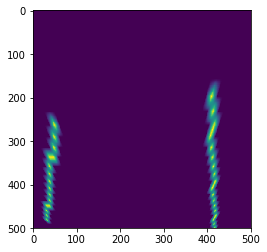

In [143]:
# 3300 for a good one
# 3978 for a bad one
warped, hist, roi, peaks, approx, lanes = detect_lane_from_image(imgs[20], height, width)
show(warped)

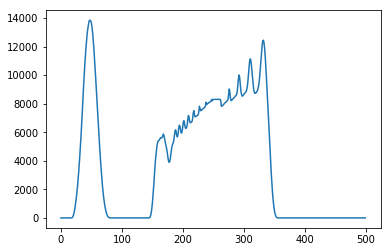

In [692]:
plt(hist)

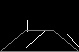

In [701]:
imshow(roi)

In [41]:
find_peaks(hist, prominence=1000, height=1000, distance=125)

(array([ 47, 332]),
 {'peak_heights': array([13846., 12448.]),
  'prominences': array([13846., 12448.]),
  'left_bases': array([ 18, 144]),
  'right_bases': array([ 81, 356])})

In [40]:
peaks

array([ 47, 332])

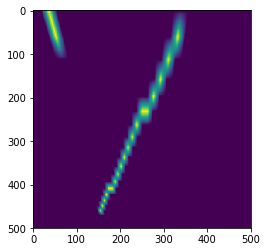

In [39]:
show(warped)

In [36]:
lines = cv2.HoughLinesP(warped, rho=2, theta=4*np.pi/180, threshold=500, minLineLength=150, maxLineGap=100)
print(len(lines), lines[0:20])

19 [[[155 470 352  27]]

 [[152 470 354  15]]

 [[150 467 355   6]]

 [[148 458 351   2]]

 [[149 461 353   2]]

 [[158 470 351  35]]

 [[146 455 348   2]]

 [[161 470 349  47]]

 [[145 452 345   2]]

 [[150 466 355   4]]

 [[164 470 348  55]]

 [[147 458 350   2]]

 [[149 437 343   2]]

 [[153 470 353  21]]

 [[186 422 348  58]]

 [[153 424 341   2]]

 [[156 470 352  30]]

 [[151 469 354  12]]

 [[188 422 347  65]]]


In [37]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(lines[:,0,:])
kmeans.cluster_centers_

array([[152.17647059, 461.        , 350.23529412,  15.64705882],
       [187.        , 422.        , 347.5       ,  61.5       ]])

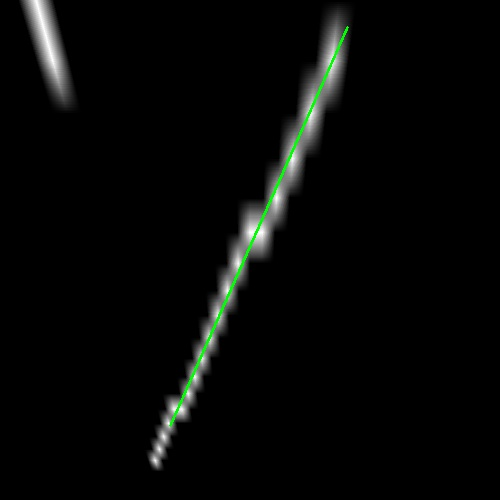

In [47]:
imshow(approx)

In [60]:
np.array(lanes).sum(axis=0) / len(lanes)

array([170.37931034, 425.44827586, 347.4137931 ,  27.4137931 ])